# Установим все необходимые библиотеки

In [1]:
!nvidia-smi

Tue Mar 30 15:46:35 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Обновление tensorflow
!pip install tensorflow --upgrade
# Загрузка модели efficientnet
!pip install -q efficientnet
# Загружаем обвязку под keras для использования продвинутых библиотек аугментации, например, albuminations
!pip install git+https://github.com/mjkvaak/ImageDataAugmentor

  Cloning https://github.com/mjkvaak/ImageDataAugmentor to /tmp/pip-req-build-gtqhcr2s
  Running command git clone -q https://github.com/mjkvaak/ImageDataAugmentor /tmp/pip-req-build-gtqhcr2s
  Created wheel for ImageDataAugmentor: filename=ImageDataAugmentor-0.0.0-py3-none-any.whl size=29531 sha256=d25182f54802e4492e914acc0ce50df4233e5687fd349a9d0a326150b76296bc
  Stored in directory: /tmp/pip-ephem-wheel-cache-zgic8mp1/wheels/c9/bd/73/9cfa59d2393dae55bbcc30f5aa901f55fe531c66efebbc8fc3
Successfully built ImageDataAugmentor


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
import random as rn
import seaborn as sns
import pickle
import zipfile
import csv
import sys
import os
import shutil

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.applications.xception import Xception
import efficientnet.tfkeras as efn
from tensorflow.keras.layers import *
import tensorflow.keras as keras
import tensorflow.keras.models as M
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import tensorflow.keras.callbacks as C
from tensorflow.keras.preprocessing import image

import albumentations as A
from ImageDataAugmentor.image_data_augmentor import *

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score

import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

Python       : 3.7.9 | packaged by conda-forge | (default, Feb 13 2021, 20:03:11) 
Numpy        : 1.19.5
Tensorflow   : 2.4.1
Keras        : 2.4.0


In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Функции

In [5]:
def print_all_classes():
    
    
    '''Вывод 1й картинки каждого класса машин'''

    
    cols = 5
    rows = 2
    fig = plt.figure(figsize=(2.5 * cols - 1, 2.5 * rows - 1))

    count = 0
    for i in range(cols):
        for j in range(rows):
            image = PIL.Image.open(
                PATH+'car/train/'+str(count)+'/'+os.listdir(PATH+'car/train/'+str(count))[0])
            ax = fig.add_subplot(rows, cols, i * rows + j + 1)
            ax.grid('off')
            ax.axis('off')
            ax.imshow(image)
            ax.set_title(f'Category: {count}')
            count += 1

    plt.show()

In [6]:
def print_n_class(number):
    
    
    '''Вывод 10-ти случайных картинок конкретного класса'''
    
    
    cols = 5
    rows = 2

    fig = plt.figure(figsize=(2.5 * cols - 1, 2.5 * rows - 1))
    fig.suptitle(f'Случайные 10 машин из {number} категории')
    for i in range(cols):
        for j in range(rows):
            image = PIL.Image.open(PATH+'car'+f'/train/{number}/'+os.listdir(PATH+'car'+f'/train/{number}/')[
                                   np.random.randint(0, len(os.listdir(PATH+'car'+f'/train/{number}/')), 1)[0]])
            ax = fig.add_subplot(rows, cols, i * rows + j + 1)
            ax.grid('off')
            ax.axis('off')
            ax.imshow(image)
    plt.show()

# Основные настройки

In [7]:
# Внесём основные настройки, чтобы было удобнее их перебирать в дальнейшем:

# В setup выносим основные настройки: так удобнее их перебирать в дальнейшем.

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
rn.seed(RANDOM_SEED)

EPOCHS               = 10  # эпох на обучение
BATCH_SIZE           = 64 # уменьшаем batch если сеть большая, иначе не поместится в память на GPU
LR                   = 1e-3
VAL_SPLIT            = 0.2 # сколько данных выделяем на тест = 20%

CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 224 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = '/kaggle/input/sf-dl-car-classification/'
PATH = "/kaggle/working/" # рабочая директория

# EDA (Разведывательный анализ данных)

In [8]:
train_df = pd.read_csv(DATA_PATH+"train.csv")
sample_submission = pd.read_csv(DATA_PATH+"sample-submission.csv")
train_df.head()

,Id,Category
0,100155.jpg,0
1,100306.jpg,0
2,100379.jpg,0
3,100380.jpg,0
4,100389.jpg,0


In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        15561 non-null  object
 1   Category  15561 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.3+ KB


In [10]:
train_df['Category'].value_counts()

1    1971
8    1765
6    1733
5    1631
0    1613
3    1528
2    1458
4    1400
9    1255
7    1207
Name: Category, dtype: int64

<AxesSubplot:>

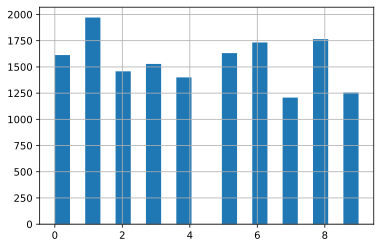

In [11]:
train_df['Category'].hist(bins = 20)

Распределение классов достаточно равномерное — это хорошо.

In [12]:
print('Распаковываем картинки')
#Will unzip the files so that you can see them..
for data_zip in ['train.zip', 'test.zip']:
    with zipfile.ZipFile(DATA_PATH+data_zip,"r") as z:
        z.extractall(PATH+'car/')

print('Распаковка завершена')

Распаковываем картинки
Распаковка завершена


In [13]:
print(os.listdir(PATH+'/car/train/'))

['1', '7', '4', '5', '9', '8', '0', '3', '6', '2']


## Выведем примеры изображений из разных классов:

### Обзор всех классов

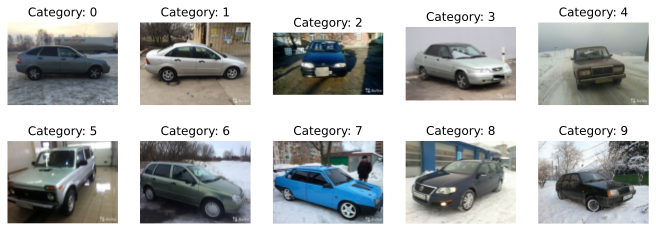

In [14]:
print_all_classes()

### Случайные 10 машин из 0-вой категории (Lada Priora)

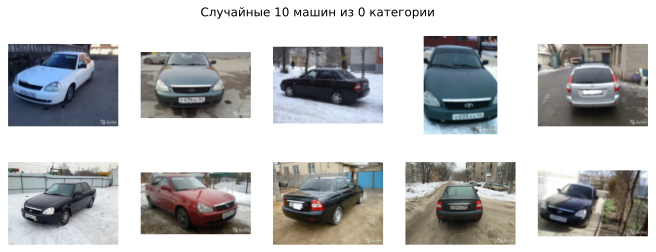

In [15]:
print_n_class(0)

### Случайные 10 машин из 1-вой категории (Ford Focus)

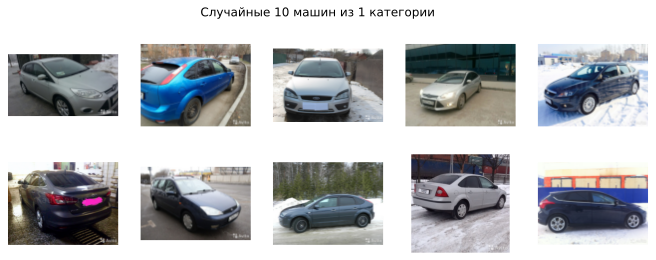

In [16]:
print_n_class(1)

### Случайные 10 машин из 2-ой категории (Lada Samara 2114)

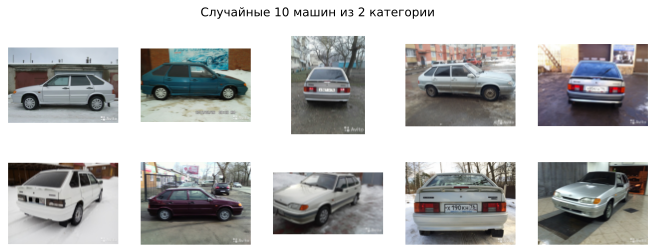

In [17]:
print_n_class(2)

### Случайные 10 машин из 3-ей категории (Lada 110)

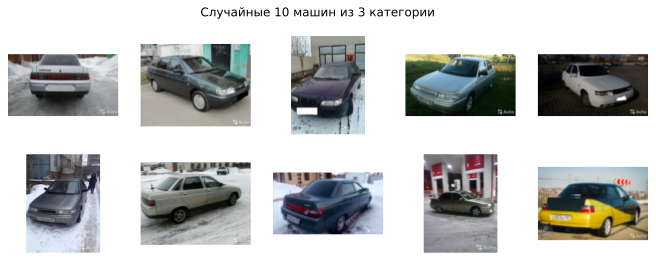

In [18]:
print_n_class(3)

### Случайные 10 машин из 4-ой категории (Lada 2107)

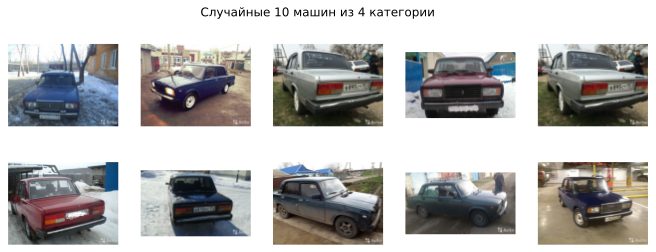

In [19]:
print_n_class(4)

### Случайные 10 машин из 5-ой категории (Lada Niva)

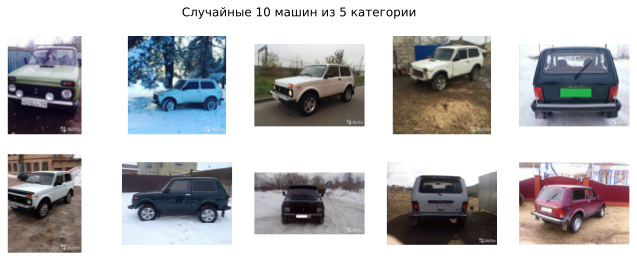

In [20]:
print_n_class(5)

### Случайные 10 машин из 6-ой категории (Lada Kalina)

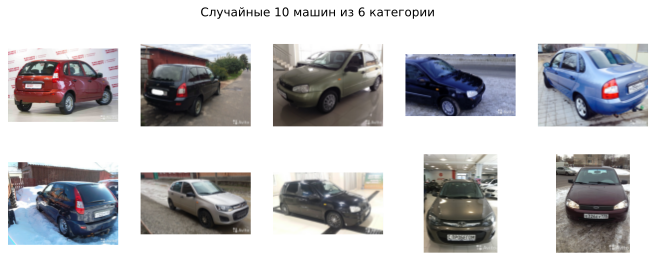

In [21]:
print_n_class(6)

### Случайные 10 машин из 7-ой категории (Lada Samara 2109)

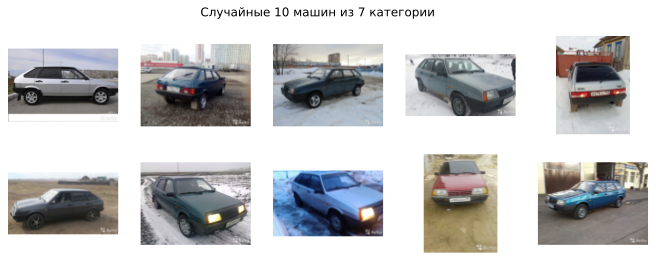

In [22]:
print_n_class(7)

### Случайные 10 машин из 8-ой категории (Volkswagen Passat)

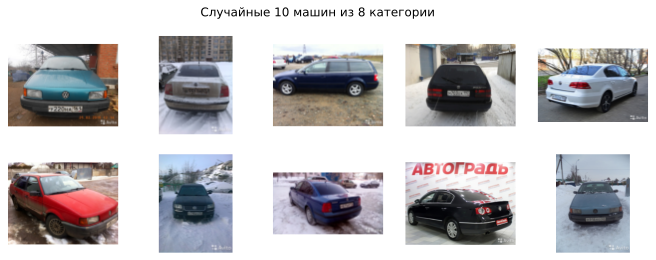

In [23]:
print_n_class(8)

### Случайные 10 машин из 9-ой категории (Lada Samara 21099)

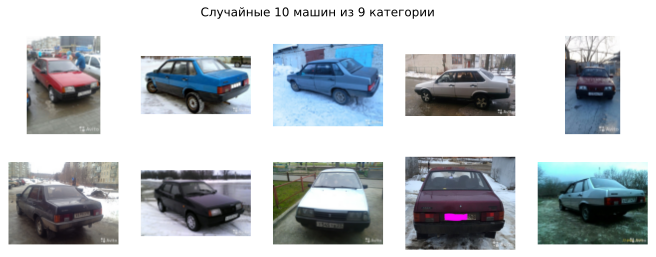

In [24]:
print_n_class(9)

### Рассмотрим подробнее одну картинку

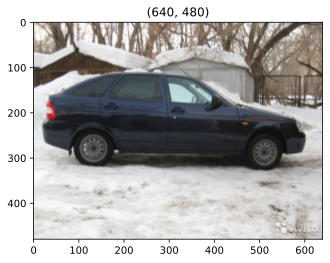

In [25]:
image = PIL.Image.open(PATH+'car/train/0/100380.jpg')
imgplot = plt.imshow(image)
plt.title(f'{image.size}')
plt.show()

Исходя из данных, можно сделать вывод, что:

Для классификации представлены фотографии 10 категорий авто Lada

Категории достаточно сбалансированны по кол-ву фото

Размеры фотографий различаются, но в основном 640 на 480. Цветные.

Всего 22236 фото в том числе, из них 15561 фото в трейне и 6675 в тесте

Кол-во фото в трейне не достаточно для хорошего обучения модели нейронной сети, поэтому будем применять различные виды аугментации данных

## Подготовка данных

В данном случае аугментация очень сильно пригодится,так как у нас количество кртинок не так много

Воспользуемся помощью библиотеки albumentations 

In [26]:
# АУГМЕНТАЦИЯ ДАННЫХ
AUGMENTATIONS = A.Compose([

    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=30,
             interpolation=1,
             border_mode=4,
             value=None,
             mask_value=None,
             always_apply=False, p=0.5),
    A.OneOf([
        A.CenterCrop(height=224, width=200),
        A.CenterCrop(height=200, width=224), ],
        p=0.5),
    A.OneOf([
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3),
        A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1)],
        p=0.5),
    A.GaussianBlur(p=0.05),
    A.HueSaturationValue(p=0.5),
    A.RGBShift(p=0.5),
    A.FancyPCA(alpha=0.1, always_apply=False, p=0.5),
    A.Resize(IMG_SIZE, IMG_SIZE)])

train_datagen = ImageDataAugmentor(
    rescale=1. / 255,
    augment=AUGMENTATIONS,
    validation_split=VAL_SPLIT)

test_datagen = ImageDataAugmentor(rescale=1. / 255)

In [27]:
# ГЕНЕРАЦИЯ ДАННЫХ

train_generator = train_datagen.flow_from_directory(
    PATH+'car/train/',      # директория где расположены папки с картинками
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training')  # set as training data

test_generator = train_datagen.flow_from_directory(
    PATH+'car/train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation')  # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe(
    dataframe=sample_submission,
    directory=PATH+'car/test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

/opt/conda/lib/python3.7/site-packages/ImageDataAugmentor/image_data_augmentor.py:332: UserWarning: Passing `seed` in `.flow_from_directory` has been been removed: pass  `seed` as parameter in `ImageDataAugmentor(..., seed=...)` instead
  warnings.warn('Passing `seed` in `.flow_from_directory` has been been removed: pass  `seed` '


Found 12452 images belonging to 10 classes.
Found 3109 images belonging to 10 classes.
Found 6675 validated image filenames.


/opt/conda/lib/python3.7/site-packages/ImageDataAugmentor/image_data_augmentor.py:455: UserWarning: Passing `seed` in `.flow_from_datagrame` has been been removed: pass  `seed` as parameter in `ImageDataAugmentor(..., seed=...)` instead
  warnings.warn('Passing `seed` in `.flow_from_datagrame` has been been removed: pass  `seed` '


## Строим модель

Загружаем предобученную сеть FixEfficientNetB7

In [28]:
base_model = efn.EfficientNetB7(weights='imagenet', include_top=False, input_shape = input_shape)

258441216/258434480 [==============================] - 3s 0us/step


In [29]:
base_model.summary()

Model: "efficientnet-b7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 64) 1728        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 64) 256         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 64) 0           stem_bn[0][0]                    
____________________________________________________________________________________

Для начала нужно заморозить веса и обучить только голову для того,

чтобы обученные признаки на Imagenet не затиралисьв самом начале нащего обучения

In [30]:
base_model.trainable = False

Устанавливаем новую «голову» (head):

In [31]:
model = M.Sequential()
model.add(base_model)
model.add(L.GlobalAveragePooling2D()) # объединяем все признаки в единый вектор
#добавляем ещё один полносвязный слой, dropout и batch-нормализацию
model.add(L.Dense(256, activation='relu'))
model.add(L.BatchNormalization())
model.add(L.Dropout(0.25))
model.add(L.Dense(CLASS_NUM,activation='softmax'))

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b7 (Functional) (None, 7, 7, 2560)        64097680  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2560)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               655616    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 64,756,890
Trainable params: 658,698
Non-trainable params: 64,098,192
______________________________________

In [33]:
print(f'Кол-во слоёв {len(model.layers)}')

Кол-во слоёв 6


Проверка трейн статуса каждого слоя

In [34]:
for layer in model.layers:
    print(layer,'-->' ,layer.trainable, '\n')

<tensorflow.python.keras.engine.functional.Functional object at 0x7fe79d4b9190> --> False 

<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7fe79ddd5e10> --> True 

<tensorflow.python.keras.layers.core.Dense object at 0x7fe73c326790> --> True 

<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fe79dddb490> --> True 

<tensorflow.python.keras.layers.core.Dropout object at 0x7fe79def9910> --> True 

<tensorflow.python.keras.layers.core.Dense object at 0x7fe73c2bff50> --> True 



## 1) Обучаем модель

Добавим ModelCheckpoint. Эта функция позволяет сохранять прогресс обучения модели, чтобы в нужный момент можно было его подгрузить и дообучить модель.

In [35]:
model.compile(loss='categorical_crossentropy',
             optimizer=optimizers.Adam(lr=LR),
             metrics=['accuracy'])
checkpoint = ModelCheckpoint('best_model.hdf5',
                             monitor=['val_accuracy'],
                             verbose=1,
                             mode='max')
earlystop = EarlyStopping(monitor='accuracy',
                          patience=5,
                          restore_best_weights=True)
callbacks_list = [checkpoint]

Обучаем:

In [36]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples//train_generator.batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples//test_generator.batch_size,
    epochs=EPOCHS,
    callbacks=callbacks_list
)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
194/194 [==============================] - 214s 997ms/step - loss: 2.1106 - accuracy: 0.3130 - val_loss: 1.2292 - val_accuracy: 0.5602

Epoch 00001: saving model to best_model.hdf5
Epoch 2/10
194/194 [==============================] - 184s 949ms/step - loss: 1.4991 - accuracy: 0.4791 - val_loss: 1.0701 - val_accuracy: 0.6224

Epoch 00002: saving model to best_model.hdf5
Epoch 3/10
194/194 [==============================] - 183s 942ms/step - loss: 1.3590 - accuracy: 0.5231 - val_loss: 0.9954 - val_accuracy: 0.6471

Epoch 00003: saving model to best_model.hdf5
Epoch 4/10
194/194 [==============================] - 184s 950ms/step - loss: 1.3147 - accuracy: 0.5375 - val_loss: 0.9290 - val_accuracy: 0.6693

Epoch 00004: saving model to best_model.hdf5
Epoch 5/10
194/194 [==============================] - 183s 940ms/step - loss: 1.2691 - accuracy: 0.5542 - val_loss: 0.9092 - val_accuracy: 0.6852

Epoch 00005: saving model to best_model.hdf5
Epoch 6/10
194/194 [====================

охраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model):

In [37]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


49/49 [==============================] - 38s 775ms/step - loss: 0.8062 - accuracy: 0.7202
Accuracy: 72.02%


In [38]:
model.save(PATH+'model_last_1.hdf5')
model.load_weights('best_model.hdf5')

В итоге точность нашей модели составила 70.41%

## 2) Обучение модели с FineTuning - обучение половины весов FixEfficientNetB7

In [39]:
print("Коо-во слоёв в base_model: ", len(base_model.layers))

Коо-во слоёв в base_model:  806


In [40]:
base_model.trainable = True

# Выполняем точную настройку, начиная с этого слоя.
fine_tune_at = len(base_model.layers)//2

# Замораживаем веса всех слоёв до инлекса fine_tune_at
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [41]:
len(base_model.trainable_variables)

354

In [42]:
for layer in model.layers:
    print(layer,'-->' ,layer.trainable, '\n')

<tensorflow.python.keras.engine.functional.Functional object at 0x7fe79d4b9190> --> True 

<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7fe79ddd5e10> --> True 

<tensorflow.python.keras.layers.core.Dense object at 0x7fe73c326790> --> True 

<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fe79dddb490> --> True 

<tensorflow.python.keras.layers.core.Dropout object at 0x7fe79def9910> --> True 

<tensorflow.python.keras.layers.core.Dense object at 0x7fe73c2bff50> --> True 



In [43]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
rn.seed(RANDOM_SEED)

EPOCHS               = 10  # эпох на обучение
BATCH_SIZE           = 16 # уменьшаем batch если сеть большая, иначе не поместится в память на GPU
LR                   = 1e-4
VAL_SPLIT            = 0.2 # сколько данных выделяем на тест = 20%

CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 224 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

In [44]:
# ГЕНЕРАЦИЯ ДАННЫХ

train_generator = train_datagen.flow_from_directory(
    PATH+'car/train/',      # директория где расположены папки с картинками
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training')  # set as training data

test_generator = train_datagen.flow_from_directory(
    PATH+'car/train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation')  # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe(
    dataframe=sample_submission,
    directory=PATH+'car/test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

Found 12452 images belonging to 10 classes.
Found 3109 images belonging to 10 classes.
Found 6675 validated image filenames.


In [45]:
model.compile(loss="categorical_crossentropy",
              optimizer=optimizers.Adam(lr=LR), 
              metrics=["accuracy"])

# Добавим ModelCheckpoint чтоб сохранять прогресс обучения модели и можно было потом подгрузить и дообучить модель.
checkpoint = ModelCheckpoint('best_model.hdf5', 
                             monitor=['accuracy'], 
                             verbose=1, 
                             mode='max')
earlystop = EarlyStopping(monitor='accuracy', 
                          patience=5, 
                          restore_best_weights=True)
callbacks_list = [checkpoint, earlystop]

In [46]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples//train_generator.batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples//test_generator.batch_size,
    epochs=EPOCHS,
    callbacks=callbacks_list)

Epoch 1/10
778/778 [==============================] - 278s 325ms/step - loss: 1.4006 - accuracy: 0.5230 - val_loss: 0.3897 - val_accuracy: 0.8582

Epoch 00001: saving model to best_model.hdf5
Epoch 2/10
778/778 [==============================] - 247s 317ms/step - loss: 0.5348 - accuracy: 0.8106 - val_loss: 0.2792 - val_accuracy: 0.9053

Epoch 00002: saving model to best_model.hdf5
Epoch 3/10
778/778 [==============================] - 249s 319ms/step - loss: 0.3744 - accuracy: 0.8706 - val_loss: 0.2454 - val_accuracy: 0.9182

Epoch 00003: saving model to best_model.hdf5
Epoch 4/10
778/778 [==============================] - 248s 319ms/step - loss: 0.3176 - accuracy: 0.8866 - val_loss: 0.2028 - val_accuracy: 0.9304

Epoch 00004: saving model to best_model.hdf5
Epoch 5/10
778/778 [==============================] - 262s 337ms/step - loss: 0.2599 - accuracy: 0.9063 - val_loss: 0.1963 - val_accuracy: 0.9304

Epoch 00005: saving model to best_model.hdf5
Epoch 6/10
778/778 [====================

In [47]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

195/195 [==============================] - 37s 187ms/step - loss: 0.1761 - accuracy: 0.9485
Accuracy: 94.85%


In [48]:
model.save(PATH+'model_last_2.hdf5')
model.load_weights('best_model.hdf5')

В итоге точность нашей модели составила 94.89%

### 3) Обучение модели с FineTuning - обучение всех весов FixEfficientNetB7 и дообучение

In [49]:
base_model.trainable = True

In [50]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
rn.seed(RANDOM_SEED)

EPOCHS               = 5  # эпох на обучение
BATCH_SIZE           = 8 # уменьшаем batch если сеть большая, иначе не поместится в память на GPU
LR                   = 1e-5
VAL_SPLIT            = 0.2 # сколько данных выделяем на тест = 20%

CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 224 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

In [51]:
# ГЕНЕРАЦИЯ ДАННЫХ

train_generator = train_datagen.flow_from_directory(
    PATH+'car/train/',      # директория где расположены папки с картинками
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training')  # set as training data

test_generator = train_datagen.flow_from_directory(
    PATH+'car/train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation')  # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe(
    dataframe=sample_submission,
    directory=PATH+'car/test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

Found 12452 images belonging to 10 classes.
Found 3109 images belonging to 10 classes.
Found 6675 validated image filenames.


In [52]:
model.compile(loss="categorical_crossentropy",
              optimizer=optimizers.Adam(lr=LR), 
              metrics=["accuracy"])

# Добавим ModelCheckpoint чтоб сохранять прогресс обучения модели и можно было потом подгрузить и дообучить модель.
checkpoint = ModelCheckpoint('best_model.hdf5', 
                             monitor=['accuracy'], 
                             verbose=1, 
                             mode='max')
earlystop = EarlyStopping(monitor='accuracy', 
                          patience=5, 
                          restore_best_weights=True)
callbacks_list = [checkpoint, earlystop]

In [53]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples//train_generator.batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples//test_generator.batch_size,
    epochs=EPOCHS,
    callbacks=callbacks_list)

Epoch 1/5
1556/1556 [==============================] - 643s 394ms/step - loss: 0.2201 - accuracy: 0.9241 - val_loss: 0.1615 - val_accuracy: 0.9559

Epoch 00001: saving model to best_model.hdf5
Epoch 2/5
1556/1556 [==============================] - 610s 392ms/step - loss: 0.1801 - accuracy: 0.9375 - val_loss: 0.1410 - val_accuracy: 0.9584

Epoch 00002: saving model to best_model.hdf5
Epoch 3/5
1556/1556 [==============================] - 611s 393ms/step - loss: 0.1449 - accuracy: 0.9499 - val_loss: 0.1490 - val_accuracy: 0.9562

Epoch 00003: saving model to best_model.hdf5
Epoch 4/5
1556/1556 [==============================] - 613s 394ms/step - loss: 0.1447 - accuracy: 0.9493 - val_loss: 0.1360 - val_accuracy: 0.9601

Epoch 00004: saving model to best_model.hdf5
Epoch 5/5
1556/1556 [==============================] - 614s 395ms/step - loss: 0.1235 - accuracy: 0.9563 - val_loss: 0.1316 - val_accuracy: 0.9636

Epoch 00005: saving model to best_model.hdf5


In [54]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

389/389 [==============================] - 39s 101ms/step - loss: 0.1376 - accuracy: 0.9598
Accuracy: 95.98%


In [55]:
model.save(PATH+'model_last_3.hdf5')
model.load_weights('best_model.hdf5')

В итоге точность нашей модели составила 96.08%

## 4) Увеличение размера изображения и понижение уровня аугментации

In [56]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
rn.seed(RANDOM_SEED)

EPOCHS               = 5  # эпох на обучение
BATCH_SIZE           = 2 # уменьшаем batch если сеть большая, иначе не поместится в память на GPU
LR                   = 1e-5
VAL_SPLIT            = 0.2 # сколько данных выделяем на тест = 20%

CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 512 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

In [57]:
AUGMENTATIONS = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5),
    albumentations.Rotate(limit=30, 
                          interpolation=1, 
                          border_mode=4, 
                          value=None, 
                          mask_value=None, 
                          always_apply=False, 
                          p=0.5)])

train_datagen = ImageDataAugmentor(
    rescale=1. / 255,
    augment=AUGMENTATIONS,
    validation_split=VAL_SPLIT)

test_datagen = ImageDataAugmentor(rescale=1. / 255)

In [58]:
# ГЕНЕРАЦИЯ ДАННЫХ

train_generator = train_datagen.flow_from_directory(
    PATH+'car/train/',      # директория где расположены папки с картинками
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training')  # set as training data

test_generator = train_datagen.flow_from_directory(
    PATH+'car/train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation')  # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe(
    dataframe=sample_submission,
    directory=PATH+'car/test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

Found 12452 images belonging to 10 classes.
Found 3109 images belonging to 10 classes.
Found 6675 validated image filenames.


Создадим сеть заново с новым размером входных данных

In [59]:
base_model = efn.EfficientNetB7(weights='imagenet', 
                                include_top=False, 
                                input_shape = input_shape)

In [60]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
rn.seed(RANDOM_SEED)

EPOCHS               = 5  # эпох на обучение
BATCH_SIZE           = 2 # уменьшаем batch если сеть большая, иначе не поместится в память на GPU
LR                   = 1e-5
VAL_SPLIT            = 0.2 # сколько данных выделяем на тест = 20%

CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 512 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

In [61]:
model.compile(loss='categorical_crossentropy',
             optimizer=optimizers.Adam(lr=LR),
             metrics=['accuracy'])

model.load_weights('best_model.hdf5')

callbacks_list = [checkpoint, earlystop]

In [62]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples//train_generator.batch_size,
    validation_data = test_generator, 
    validation_steps = test_generator.samples//test_generator.batch_size,
    epochs = EPOCHS,
    callbacks = callbacks_list
    )

Epoch 1/5
6226/6226 [==============================] - 3314s 528ms/step - loss: 1.1515 - accuracy: 0.6962 - val_loss: 0.1306 - val_accuracy: 0.9720

Epoch 00001: saving model to best_model.hdf5
Epoch 2/5
6226/6226 [==============================] - 3280s 527ms/step - loss: 0.7025 - accuracy: 0.8335 - val_loss: 0.1325 - val_accuracy: 0.9736

Epoch 00002: saving model to best_model.hdf5
Epoch 3/5
6226/6226 [==============================] - 3262s 524ms/step - loss: 0.6225 - accuracy: 0.8629 - val_loss: 0.1334 - val_accuracy: 0.9749

Epoch 00003: saving model to best_model.hdf5
Epoch 4/5
6226/6226 [==============================] - 3260s 524ms/step - loss: 0.5968 - accuracy: 0.8652 - val_loss: 0.1214 - val_accuracy: 0.9768

Epoch 00004: saving model to best_model.hdf5
Epoch 5/5
6226/6226 [==============================] - 3261s 524ms/step - loss: 0.5414 - accuracy: 0.8746 - val_loss: 0.1331 - val_accuracy: 0.9752

Epoch 00005: saving model to best_model.hdf5


In [63]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

1555/1555 [==============================] - 150s 96ms/step - loss: 0.1292 - accuracy: 0.9775
Accuracy: 97.75%


In [64]:
model.save(PATH+'model_last_4.hdf5')
model.load_weights('best_model.hdf5')

В итоге точность нашей модели составила 97.68%

# Предсказание на тестовых данных

In [65]:
test_sub_generator.samples

6675

In [66]:
test_sub_generator.reset()
predictions = model.predict_generator(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


3338/3338 [==============================] - 312s 92ms/step


In [67]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 
                           'Category':predictions}, 
                          columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission.csv', index=False)
print('Save submit')

Save submit


In [68]:
submission.head()

,Id,Category
0,305108.jpg,7
1,295075.jpg,6
2,31197.jpg,4
3,93598.jpg,7
4,87877.jpg,9


# Test Time Augmentation

Аугментируем тестовые изображения и сделаем несколько предсказаний одной картинки в разном виде.

Взяв среднее значение из нескольких предсказаний получим итоговое предсказание.

In [69]:
model.load_weights('best_model.hdf5')

In [70]:
AUGMENTATIONS = A.Compose([

    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=30,
             interpolation=1,
             border_mode=4,
             value=None,
             mask_value=None,
             always_apply=False, p=0.5),
    A.OneOf([
        A.CenterCrop(height=224, width=200),
        A.CenterCrop(height=200, width=224), ],
        p=0.5),
    A.OneOf([
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3),
        A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1)],
        p=0.5),
    A.GaussianBlur(p=0.05),
    A.HueSaturationValue(p=0.5),
    A.RGBShift(p=0.5),
    A.FancyPCA(alpha=0.1, always_apply=False, p=0.5),
    A.Resize(IMG_SIZE, IMG_SIZE)])

In [71]:
test_datagen = ImageDataAugmentor(
    rescale=1. / 255,
    augment=AUGMENTATIONS,
    validation_split=VAL_SPLIT)

In [72]:
test_sub_generator = test_datagen.flow_from_dataframe(
    dataframe=sample_submission,
    directory=PATH+'car/test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

Found 6675 validated image filenames.


/opt/conda/lib/python3.7/site-packages/ImageDataAugmentor/image_data_augmentor.py:455: UserWarning: Passing `seed` in `.flow_from_datagrame` has been been removed: pass  `seed` as parameter in `ImageDataAugmentor(..., seed=...)` instead
  warnings.warn('Passing `seed` in `.flow_from_datagrame` has been been removed: pass  `seed` '


In [73]:
tta_steps = 10 # берем среднее из 10 предсказаний
predictions = []

for i in range(tta_steps):
    preds = model.predict_generator(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
    predictions.append(preds)

pred = np.mean(predictions, axis=0)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


3338/3338 [==============================] - 317s 95ms/step


In [74]:
predictions = np.argmax(pred, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

In [75]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission_TTA.csv', index=False)
print('Save submit')

Save submit


In [76]:
submission.head()

,Id,Category
0,305108.jpg,7
1,295075.jpg,1
2,31197.jpg,4
3,93598.jpg,7
4,87877.jpg,9


In [77]:
!rm -rf /kaggle/working/car/*

In [78]:
!find /kaggle/working -name "*.hdf5" -type f -delete

В этом ноутбуке были применены методы:

transfer learning

fine-tuning

настройка LR, optimizer

подобраны переменные (размер картинки, батч и т.д.)

SOTA архитектура сетей - EfficientNetB7

добавлена Batch Normalization и изменена архитектура “головы”

применены дополнительные функции callback Keras https://keras.io/callbacks/

TTA (Test Time Augmentation)